In [217]:
import sys
import time
import requests
from bs4 import BeautifulSoup
from openpyxl import Workbook
import random
import pickle as pck
import re

In [17]:
#reload(sys)
#sys.setdefaultencoding('utf8')

#Only for jupyter notebook
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

In [12]:
user_agent_list = [
   #Chrome
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
    'Mozilla/5.0 (Windows NT 5.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
    #Firefox
    'Mozilla/4.0 (compatible; MSIE 9.0; Windows NT 6.1)',
    'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)',
    'Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (Windows NT 6.2; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.0; Trident/5.0)',
    'Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)',
    'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; Trident/6.0)',
    'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/4.0; .NET CLR 2.0.50727; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729)'
]

In [300]:
class Paper(object):
    """A paper object, containing some basic information of a paper, currently only arxiv papers"""
    #self.nap_interval = 5. #sec
    def __init__(self, arxiv_id=None, url="https://arxiv.org/abs/", nap=5.):
        self.nap_interval = nap
        self.customized_fields = {}
        self._url_prefix = url
        if (arxiv_id is None):
            self.title = ""
            self.authors = []
            self.arxiv_id = ""
            self.link = ""
            self.link_ads = ""
            self.abstract = ""
            self.date = ""
            self.comments = ""
            self.subjects = ""
        else:
            self._find_paper(arxiv_id, url)
        
    def _find_paper(self, arxiv_id, url):
        """Find a paper according to its arxiv id"""
        self.arxiv_id = arxiv_id
        self.link = url+arxiv_id
        (self.title, self.authors, self.link_ads, \
            self.abstract, self.date, self.comments, self.subjects) = \
            self._read_page(arxiv_id, self.link, nap=self.nap_interval)
        return
    
    @staticmethod
    def _read_page(arxiv_id, url, nap=5.):
        """Read the page of an arxiv paper,
        and return title, authors, the ads link, abstract"""
        header = {'User-Agent':random.choice(user_agent_list)}
        try:
            source_code = requests.get(url, headers=header)
            source_code.raise_for_status()
        except HTTPError as e:
            print(e)
            return ("", [], "", "", "", "", "")
        
        plain_text = source_code.text
        soup = BeautifulSoup(plain_text)

#        title_str = str(soup.find("meta", {"name":"citation_title"})).split("\"")
        # content is in the second place
#        title = title_str[1]
        title = soup.find("meta", {"name":"citation_title"}).get("content").strip()
        #authors
        #authors_str = str(soup.findAll("meta", {"name":"citation_author"})).split("/")
        authors_list = []
#        for cc in authors_str:
#            if(cc.find("content")!=-1):
#                # content on the second index
#                authors_list.append(cc.split("\"")[1])
#        print(authors_list)
        for ss in soup.findAll("meta", {"name":"citation_author"}):
            authors_list.append(ss.get("content").strip())
                               
        #print(soup.findAll("meta", {"name":"citation_author"}).get("content"))
        ads_link = soup.find("a", text="NASA ADS").get('href').strip()

        abstract = soup.find("meta", {"property":"og:description"}).get("content").strip()
        date = soup.find("meta", {"name":"citation_date"}).get("content").strip()
        comments = soup.find("td", {"class":"tablecell comments mathjax"}).get_text().strip()
        #subjects = [soup.find("span",{"class":"primary-subject"}).get_text()]
        subjects = soup.find("td",{"class":"tablecell subjects"}).get_text().strip()
        
        time.sleep(random.random()*nap)
        return (title, authors_list, ads_link, abstract, date, comments, subjects)
    
    def __repr__(self):
        return "<Paper id:%s link:%s>" % (self.arxiv_id, self.link)
    
    def __str__(self):
        return "ID: %s\nTitle: %s\nAuthors: %s\nDate: %s\nAbstract: %s\nComments: %s\nLink: %s\nSubjects: %s\n" % \
            (self.arxiv_id, self.title, self._authors_in_line(), self.date, self.abstract, \
            self.comments, self.link, self.subjects)
        
    def _authors_in_line(self):
        """Return a single str of authors splitted with ; """
        s = ""
        for cc in self.authors:
            s += cc+"; "
        return s[:-2]
        
    def search_online(self):
        """Search online according to the arxiv id"""
        if(self.arxiv_id==""):
            print("The id is empty!")
            return 0
        self._find_paper(self.arxiv_id, self._url_prefix)
        return 1
    
    def customized_fields(self, key_name, value):
        self.customized_fields[key_name] = value
        
    def fetch_pdf(self):
        pass

In [437]:
#a = Paper(arxiv_id="arXiv:1909.10883")
#print(a)

In [438]:
def arxiv_reading(url=None, nap=5.):
    """Daily reading arxiv:
    save to a pickle or something"""
    if (url is None):
        url = "https://arxiv.org/list/astro-ph/new"
    header = {'User-Agent':random.choice(user_agent_list)}
    source_code = requests.get(url, headers=header) 
    #time.sleep(np.random.rand()*10)
    plain_text = source_code.text
    soup = BeautifulSoup(plain_text)
    time_str = soup.find("h3").get_text().strip()
    print(time_str)
    paper_list = []
    papers_sp = soup.find("dl")
    # =======================================================
    # Only the new papars without cross list and replacements
    # =======================================================
    #paper_list = soup.find("div", {'class': 'meta'})
    item_list_sp = papers_sp.findAll("dt")
    paper_list_sp = papers_sp.findAll("dd")
    
    if(len(item_list_sp)!=len(paper_list_sp)):
        print("Warning: Length different!")
        
    for tt, ss in zip(item_list_sp, paper_list_sp):
        paper1 = Paper()
        paper1.arxiv_id = tt.find("a", {"title":"Abstract"}).get_text().strip()
        title_sp = ss.find("div", {"class":"list-title mathjax"})
        title_sp.span.decompose()
        paper1.title = title_sp.get_text().strip()
        authors_sp = ss.find("div", {"class":"list-authors"})
        #authors_sp.span.decompose()
        authors_list_sp = authors_sp.findAll("a")
        for au in authors_list_sp:
            paper1.authors.append(au.get_text().strip())
            
        paper1.abstract = ss.find("p", {"class":"mathjax"}).get_text().strip()
        comments_sp = ss.find("div", {"class":"list-comments mathjax"})
        subjects_sp = ss.find("div", {"class":"list-subjects"})
        try:
            comments_sp.span.decompose()
            paper1.comments = comments_sp.get_text().strip()
        except AttributeError as e:
            pass
        subjects_sp.span.decompose()
        paper1.subjects = subjects_sp.get_text().strip()
        paper1.date = time_str
        #print(paper1)        
        paper_list.append(paper1)

    print("Sleep...")
    time.sleep(random.random()*nap)
    print("Awake...")
    return paper_list, time_str

In [439]:
pl, ts = arxiv_reading()

New submissions for Fri,  4 Oct 19
Sleep...
Awake...


In [440]:
with open(ts.split(",")[-1].strip().replace(" ", "_")+"_paper_list.pkl", "w") as f:
    pck.dump(pl, f)

In [304]:
print(len(pl))

51


In [428]:
class ListPapers(object):
    def __init__(self, *args, **kwargs):
        if(len(args)==0):
            self.list_paper=[]
        elif(type(args[0]) is not list):
            raise TypeError("A list of paper needed")
        else:
            self.list_paper=args[0]
        if("key_words" in kwargs):
            if ("boost" in kwargs):
                self.add_key_words(kwargs["key_words"], boost=kwargs["boost"])
            else:
                self.add_key_words(kwargs["key_words"], boost=1.)
        if("exclude_key_words" in kwargs):
            self.exclude_key_words(kwargs["exclude_key_words"])
#        if(list_paper is None):
#            self.list_paper = []
#        else:
#            self.list_paper = list_paper
            
    def __len__(self):
        try:
            return self.tot_num
        except:
            self.tot_num = len(self.list_paper)
            return self.tot_num

    def add_key_words(self, kw, boost=1.):
        """Add key words and calculate the sores in passing, key word contains upper case letter in the key_words
        list. But all other dict keys are lower cases."""
        try:
            self._boost
        except AttributeError:
            self._boost={}
        if(type(kw) is list):
            try:
                self.key_words
            except AttributeError:
                self.key_words = []
                
            if(type(boost) is not list):
                boost = [boost]*len(kw)
            for kk, bb in zip(kw, boost):
                # check if the key word already exist
                pd = sum([1 for kkk in self.key_words if kkk.lower()==kk.lower()])
                if (pd>0):
                    print("This keyword is already in the database.")
                    continue
                
                self.key_words.append(kk.strip())
                kk = kk.lower()
                self._boost[kk] = bb
                self.cal_key_word_scores(kk)
                
        elif(type(kw) is str):
            try:
                self.key_words
            except AttributeError:
                self.key_words = []
                
            # check if the key word already exist    
            pd = sum([1 for kk in self.key_words if kk.lower()==kw.lower()])
            if (pd>0):
                print("This keyword is already in the database.")
                return
            self.key_words.append(kw.strip())
            kw = kw.lower()
            self._boost[kw] = boost
            self.cal_key_word_scores(kw)
        else:
            raise TypeError("A string or a list of string should be defined as key words!")
        
        return
    
    def del_key_word(self, kw):
        """Delete an existed key word, kw must be str"""
        try:
            for kk in self.key_words:
                if(kw.strip().lower()==kk.strip().lower()):
                    self.key_words.remove(kk)
                    kk = kk.strip().lower()
                    self._boost.pop(kk, None)
                    self.scores.pop(kk, None)
                    self._update_tot_scores()
                    pass
                    return
        except AttributeError:
            print("An error occured when deleting a key word. The list of key words not defined.")
            return
        print("Murmur: key word not exist.")
        return
    
    def exclude_key_words(self, kw):
        """Exclude the kw when scoring the files."""
        if(type(kw) is str):
            try:
                self.exclude_kws.append(kw.strip())
            except AttributeError:
                self.exclude_kws = [kw.strip()]
            kw = kw.strip().lower()
            self.cal_key_word_scores(kw, exclude=True)
        elif(type(kw) is list):
            try:
                self.exclude_kws.extend([kk.strip() for kk in kw])
            except AttributeError:
                self.exclude_kws = [kk.strip() for kk in kw]
            for kk in kw:
                kk = kk.strip().lower()
                self.cal_key_word_scores(kk, exclude=True)
        else:
            raise TypeError("A string or a list of string should be defined as key words!")
        self._update_tot_scores()
        return
    
    def reset_exclude(self):
        """Delete all excluded key words"""
        try:
            del self.exclude_kws
            # The scores dict contains excluding information, but will not be used
            self._update_tot_scores()
        except AttributeError:
            print("Murmur: no key word excluded")
        return 
    
    def cal_key_word_scores(self, kw, exclude=False):
        """Calculate the key word scores, kw must be str
        Lucene method"""
        self.tot_num = len(self.list_paper)
        kw = kw.lower()
        try:
            self.scores[kw] = [0.]*self.tot_num
        except AttributeError:
            self.scores = {}
            self.scores[kw] = [0.]*self.tot_num
        if(exclude):
            for ii in range(self.tot_num):
                if(self._kw_match(self.list_paper[ii], kw)):
                    self.scores[kw][ii] = -1
        else:
            for ii in range(self.tot_num):
                self.scores[kw][ii] = self._idf(self._kw_n(kw), self.tot_num)* \
                                self._boost[kw]*self._tfnorm(kw, self.list_paper[ii], self.aver_length())
                
        self._update_tot_scores()
        return self.scores[kw]
    
    def _update_tot_scores(self):

        self.tot_scores = [0.]*self.tot_num
        for ii in range(self.tot_num):
            for kw in self.key_words:
                self.tot_scores[ii] += self.scores[kw.lower()][ii]
        try:
            self.exclude_kws
            for ii in range(self.tot_num):
                for kw in self.exclude_kws:
                    self.tot_scores[ii] *= self.scores[kw.lower()][ii]+1
        except AttributeError:
            pass
                
            
        return
            
    def _kw_match(self, pp, kw):
        """Return if the kw is in the pp paper"""
        kw = kw.strip().lower()
        if(pp.title.lower().find(kw)!=-1 or pp.abstract.lower().find(kw)!=-1):
            return True
        else:
            return False
        
    def _kw_n(self, kw):
        """Count the keywords documents"""
        return len(self.search_keyword(kw))
    
    @staticmethod
    def _idf(kw_n, doc_n):
        """Inverse Document Frequency (IDF) function"""
        return np.log(1.+(float(doc_n)-float(kw_n)+0.5)/(float(kw_n)+0.5))
    
    @staticmethod
    def _tfnorm(kw, pp, aver_length):
        """Normalized term frequency for a paper pp.
        Should title be weighted more than the abstract?"""
        tf = float(sum(1 for _ in re.finditer(kw, pp.title.lower()))+ \
            sum(1 for _ in re.finditer(kw, pp.abstract.lower())))
        k1 = 1.2 # term frequency saturation
        b = 0.75 # normlizaion of doc length
        len_doc = float(len(pp.title.strip().split())+len(pp.abstract.strip().split()))
        if (len_doc<=0.):
            print("Warning: paper is empty!")
        return tf*(k1+1.)/(tf+k1*(1.-b+b*len_doc/aver_length))
        #self.aver_length()
        
    def aver_length(self):
        """average the total length of papers"""
        try:
            return float(sum(len(pp.title.strip().split())+len(pp.abstract.strip().split()) \
                       for pp in self.list_paper))/float(self.tot_num)
        except AttributeError:
            return float(sum(len(pp.title.strip().split())+len(pp.abstract.strip().split()) \
                       for pp in self.list_paper))/float(len(self.list_paper))
    
    def search_keyword(self, kw):
        """Search the docs that contains keyword 'kw'.
        Return a list. Maybe return a ListPaper in future."""
        kw = kw.lower()
        searched_list = []
        for pp in self.list_paper:
            if(pp.title.lower().find(kw)!=-1 or pp.abstract.lower().find(kw)!=-1):
                searched_list.append(pp)
        return searched_list
    
    def head(self, n=3, score=True, sync=False, fetch=False):
        """Show the first n papers on the list according to total scores or not"""
        if(score):
            argsort_score = np.argsort(-np.array(self.tot_scores))
            for ii in range(n):
                if(sync):
                    self.list_paper[argsort_score[ii]].search_online()
                print(self.list_paper[argsort_score[ii]])
        else:
            for ii in range(n):
                if(sync):
                    self.list_paper[argsort_score[ii]].search_online()
                print(self.list_paper[ii])
                
        return
    
    def filter_subjects(self, subj):
        """Make a new list with the subjects in subj"""
        if(type(subj) is str):
            subj = [subj]
        new_list = list([pp for pp in self.list_paper if self._subj_contain(pp, subj)])
        #print(len(new_list))
        try:
            return ListPapers(new_list, key_words=self.key_words, exclude_key_words=self.exclude_key_words)
        except:
            try:
                return ListPapers(new_list, key_words=self.key_words)
            except AttributeError:
                return ListPapers(new_list)
        raise 
    
    def _subj_contain(self, pp, subj):
        """Return True if a paper pp contains any of subj as subjects"""
        # subj is a list
        for ss in subj:
            if (pp.subjects.find(ss)!=-1):
                return True
        return False
    
    def all_subjects(self):
        """Show all the subjects of the list"""
        try:
            self.subjects_list
        except AttributeError:
            self.subjects_list = []
        for pp in self.list_paper:
            subj = [cc.strip() for cc in pp.subjects.split(";")]
            for ss in subj:
                if (ss not in self.subjects_list):
                    self.subjects_list.append(ss)
        return self.subjects_list


In [429]:
lp_c = ListPapers(pl)

In [430]:
lp_c.all_subjects()

[u'Astrophysics of Galaxies (astro-ph.GA)',
 u'Cosmology and Nongalactic Astrophysics (astro-ph.CO)',
 u'Solar and Stellar Astrophysics (astro-ph.SR)',
 u'Earth and Planetary Astrophysics (astro-ph.EP)',
 u'Instrumentation and Methods for Astrophysics (astro-ph.IM)',
 u'High Energy Astrophysical Phenomena (astro-ph.HE)',
 u'High Energy Physics - Theory (hep-th)',
 u'Nuclear Theory (nucl-th)',
 u'Space Physics (physics.space-ph)',
 u'General Relativity and Quantum Cosmology (gr-qc)']

In [432]:
lp_c.add_key_words(["chemistry","Galactic center","SNR"])
#lp_c.del_key_word("Chemistry")

In [433]:
print(lp_c.tot_scores)
print(lp_c.key_words)
print(lp_c.scores["galactic center"])
print(lp_c.scores["snr"])
#print(lp_c.scores["chemistry"])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3168297931300303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.89014580842331, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.1505873268185747, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
['chemistry', 'Galactic center', 'SNR']
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3168297931300303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [434]:
lp_c.exclude_key_words("planet")
print(lp_c.scores["planet"])
print(lp_c.tot_scores)
lp_c.reset_exclude()
print(lp_c.scores["planet"])
print(lp_c.tot_scores)

[0.0, 0.0, 0.0, 0.0, -1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1, 0.0, 0.0, -1, -1, 0.0, 0.0, -1, 0.0, 0.0, 0.0, 0.0, 0.0, -1, 0.0, 0.0, -1, 0.0, 0.0, -1, -1, 0.0, 0.0, -1, 0.0, 0.0, -1, 0.0, 0.0, -1, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3168297931300303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.89014580842331, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, -1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1, 0.0, 0.0, -1, -1, 0.0, 0.0, -1, 0.0, 0.0, 0.0, 0.0, 0.0, -1, 0.0, 0.0, -1, 0.0, 0.0, -1, -1, 0.0, 0.0, -1, 0.0, 0.0, -1, 0.0, 0.0, -1, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3168297931300303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.89014580842331, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5

In [435]:
lp_d=lp_c.filter_subjects("astro-ph.CO")

In [436]:
print(lp_d.key_words)

['chemistry', 'Galactic center', 'SNR']


In [342]:
lp_c.head(sync=True)

ID: arXiv:1910.01554
Title: The role of C/O in nitrile astrochemistry in PDRs and planet-forming disks
Authors: Gal, Romane Le; Brady, Madison T.; Öberg, Karin I.; Roueff, Evelyne; Petit, Franck Le
Date: 2019/10/03
Abstract: Complex nitriles, such as HC3N, and CH3CN, are observed in a wide variety of
astrophysical environments, including at relatively high abundances in
photon-dominated regions (PDR) and the UV exposed atmospheres of planet-forming
disks. The latter have been inferred to be oxygen-poor, suggesting that these
observations may be explained by organic chemistry in C-rich environments. In
this study we first explore if the PDR complex nitrile observations can be
explained by gas-phase PDR chemistry alone if the elemental C/O ratio is
elevated. In the case of the Horsehead PDR, we find that gas-phase chemistry
with C/O $\gtrsim$ 0.9 can indeed explain the observed nitrile abundances,
increasing predicted abundances by several orders of magnitude compared to
standard C/O as

In [164]:
def pl_nap(time):
    """power law nap time"""
    a = 1.
    b = 0.75
    return a*time**b

In [150]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


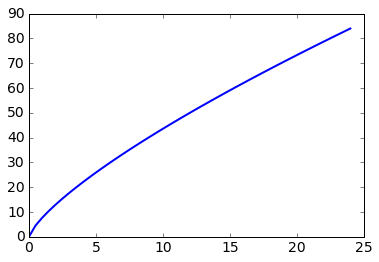

In [165]:
plot(arange(50)/49.*86400./60./60., pl_nap(arange(50)/49.*86400.)/60.)

In [222]:
pp = Paper(arxiv_id="1909.12305")

In [312]:
ll = pp.abstract.split()
ll

['Supersonic',
 'turbulence',
 'results',
 'in',
 'strong',
 'density',
 'fluctuations',
 'in',
 'the',
 'interstellar',
 'medium',
 '(ISM),',
 'which',
 'have',
 'a',
 'profound',
 'effect',
 'on',
 'the',
 'chemical',
 'structure.',
 'Particularly',
 'useful',
 'probes',
 'of',
 'the',
 'diffuse',
 'ISM',
 'are',
 'the',
 'ArH$^+$,',
 'OH$^+$,',
 'H$_2$O$^+$',
 'molecular',
 'ions,',
 'which',
 'are',
 'highly',
 'sensitive',
 'to',
 'fluctuations',
 'in',
 'the',
 'density',
 'and',
 'the',
 'H$_2$',
 'abundance.',
 'We',
 'use',
 'isothermal',
 'magnetohydrodynamic',
 '(MHD)',
 'simulations',
 'of',
 'various',
 'sonic',
 'Mach',
 'numbers,',
 '$\\mathcal{M}_s$,',
 'and',
 'density',
 'decorrelation',
 'scales,',
 '$y_{\\rm',
 'dec}$,',
 'to',
 'model',
 'the',
 'turbulent',
 'density',
 'field.',
 'We',
 'post-process',
 'the',
 'simulations',
 'with',
 'chemical',
 'models',
 'and',
 'obtain',
 'the',
 'probability',
 'density',
 'functions',
 '(PDFs)',
 'for',
 'the',
 'H$_2$,',

In [391]:
def foo(*arg, **argv):
    print(len(arg))
    return

In [395]:
foo(["a", "b"], s=1)

1


In [383]:
a = [1,3,4,5]
b = [2,3,4,6]
[ii for ii in a if (ii==bb for bb in b)]

[1, 3, 4, 5]